Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Data Reading

Import Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing Skin Cancer Data

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# image count in train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


# Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

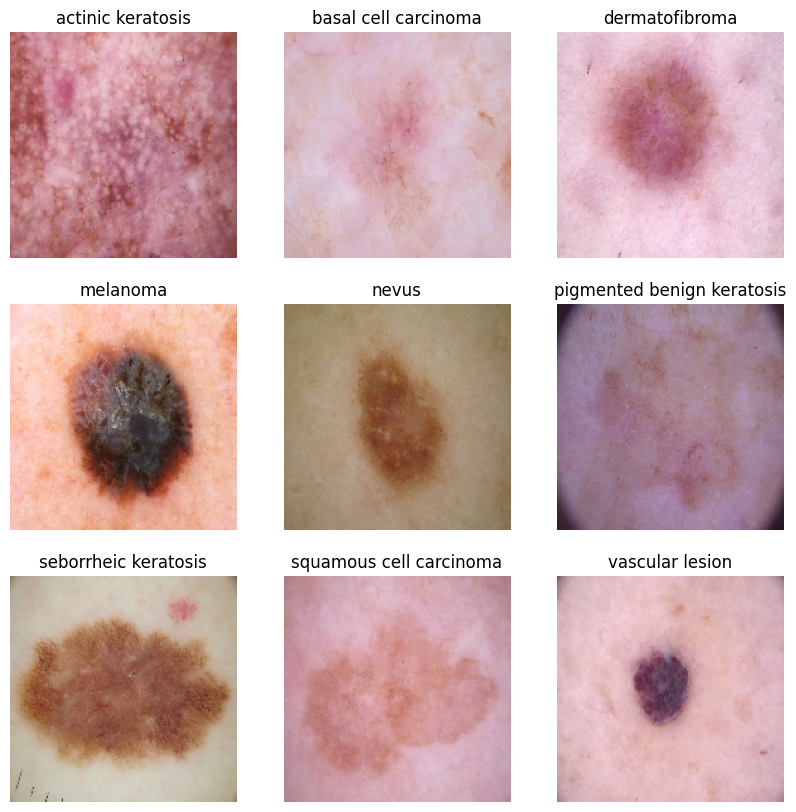

In [9]:
plt.figure(figsize=(10, 10))
index1 = 0
for class_name in class_names:
    index1 += 1
    plt.subplot(3, 3, index1)
    # Path to the image
    img_path = f"/content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/{class_name}/"
    # get the image
    img_filename = os.listdir(img_path)[3]
    # load the image
    img = load_img(os.path.join(img_path, img_filename), target_size=(180,180))
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building and Training

Normalize the layers

In [11]:
# preprocess and normalize images
normalize_layers = layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))

Model Architecture

In [12]:
# Sequential model
model = Sequential()

# Rescaling layer
model.add(normalize_layers)

# First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                        input_shape = (img_height, img_width, 32)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                        input_shape = (img_height, img_width, 32)))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution layer
model.add(layers.Conv2D(64, kernel_size=(5,5),activation='relu'))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution layer
model.add(layers.Conv2D(64, kernel_size=(5,5),activation='relu'))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropoutlayer
model.add(layers.Dropout(0.5))

#Flatten layer
model.add(layers.Flatten())

#Dense layer
model.add(layers.Dense(len(class_names), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 64)        0         
 g2D)                                                   

Compile the model

The opimizer is 'Adam', Adam optimization algorithm

The loss function is 'SparseCategoricalCrossentropy' where from_logits to False indicates that the model outputs probabilities, rather than raw logits.

Metrics 'accuracy' is used as the metric to monitor the classification accuracy of the model during training.

In [13]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 64)        0         
 g2D)                                                   

Train the model

In [15]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 132s 96ms/step - loss: 2.0721 - accuracy: 0.1942 - val_loss: 2.3651 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.9058 - accuracy: 0.2712 - val_loss: 2.1437 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 1.7867 - accuracy: 0.3477 - val_loss: 2.4729 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6524 - accuracy: 0.3979 - val_loss: 2.4268 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6256 - accuracy: 0.4224 - val_loss: 2.7347 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5425 - accuracy: 0.4509 - val_loss: 2.4651 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5141 - accuracy: 0.4621 - val_loss: 2.5357 - val_accuracy: 0.3043
Epoch 8/20


Visualizing training results

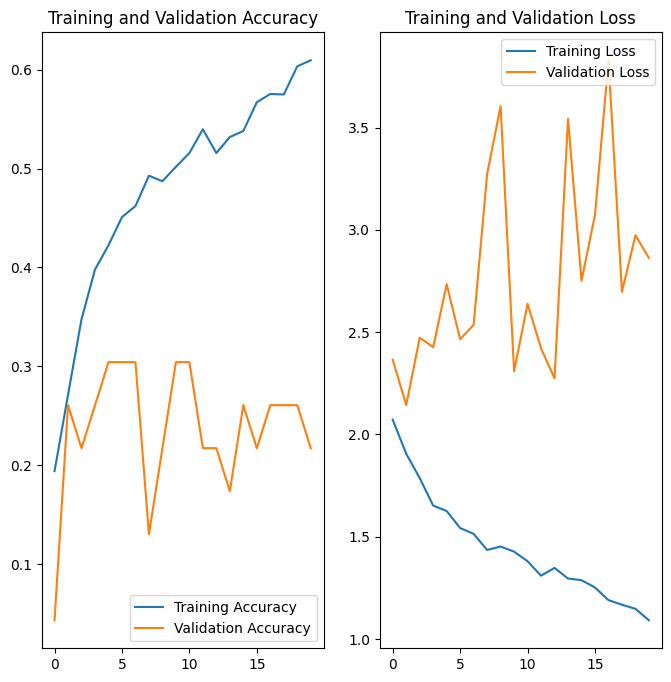

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Result of first traiaing model

In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

1/1 [==============================] - 0s 17ms/step - loss: 2.8626 - accuracy: 0.2174
Accuracy:  0.6188616156578064
Validation Accuracy:  0.21739129722118378
Loss:  1.0411951541900635
Validation Loss 2.862623691558838


Write your findings here


1.    Model is overfit difference in training ans validation with lot of diffrence in trainig and validation accuracy
2.   Training accuracy is 61%






# Data Augmentation

Using data auumentaion strategy rotation is added, mirroring image in horizontal and in vertical axis and zooming.
This technique is used to increase robustness of model resulting in improving overfitting

In [18]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

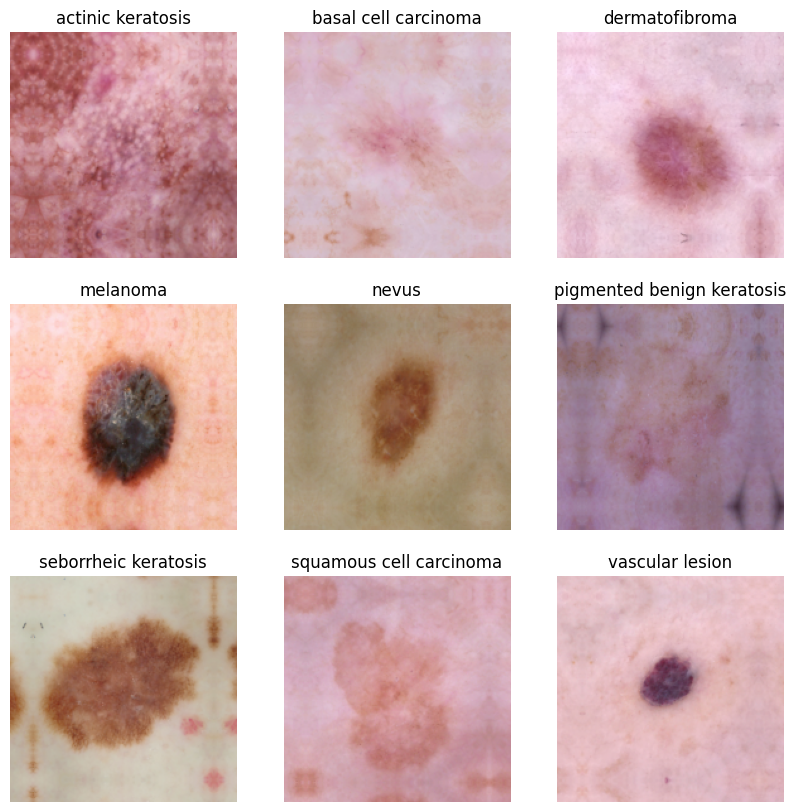

In [19]:
plt.figure(figsize=(10, 10))
index = 0
for class_name in class_names:
    index += 1
    plt.subplot(3, 3, index)
    img_path = f"/content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/{class_name}/"
    img_filename = os.listdir(img_path)[3]
    # loads image file from path
    img = load_img(os.path.join(img_path, img_filename), target_size=(180,180))
    # converts PIL image into numpy array
    img_tensor = img_to_array(img)
    # add an extra dimension
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    # augumented image
    augumented_img = data_augument(img_tensor)
    plt.imshow(augumented_img[0].numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis('off')

# Model Building and Training

In [20]:
model = Sequential()

# Rescaling layer
model.add(normalize_layers)

# First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                        input_shape = (img_height, img_width, 32)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                        input_shape = (img_height, img_width, 32)))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropoutlayer
model.add(layers.Dropout(0.25))

#Second Convolution layer
model.add(layers.Conv2D(64, kernel_size=(5,5),activation='relu'))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropoutlayer
model.add(layers.Dropout(0.25))

#Third Convolution layer
model.add(layers.Conv2D(64, kernel_size=(5,5),activation='relu'))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropoutlayer
model.add(layers.Dropout(0.5))

#Flatten layer
model.add(layers.Flatten())

#Dense layer
model.add(layers.Dense(len(class_names), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 88, 88, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 84, 84, 64)        51264     
                                                      

In [21]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
epochs =20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 37ms/step - loss: 2.0086 - accuracy: 0.2366 - val_loss: 2.2297 - val_accuracy: 0.1304
Epoch 2/20
56/56 [==============================] - 2s 35ms/step - loss: 1.8378 - accuracy: 0.3253 - val_loss: 2.3136 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 1.7077 - accuracy: 0.3850 - val_loss: 2.4851 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6394 - accuracy: 0.3990 - val_loss: 2.5276 - val_accuracy: 0.1739
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4990 - accuracy: 0.4593 - val_loss: 2.3764 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4774 - accuracy: 0.4565 - val_loss: 2.6828 - val_accuracy: 0.1739
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5427 - accuracy: 0.4358 - val_loss: 2.1816 - val_accuracy: 0.2609
Epoch 8/20
56

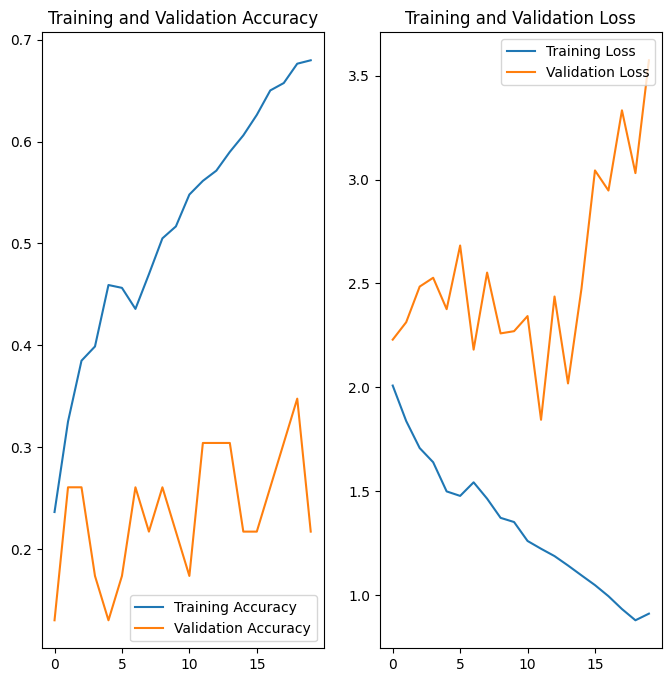

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

1/1 [==============================] - 0s 18ms/step - loss: 3.5747 - accuracy: 0.2174
Accuracy:  0.7483258843421936
Validation Accuracy:  0.21739129722118378
Loss:  0.6920100450515747
Validation Loss 3.5747017860412598



Observation
1.   Model is overfit
2.   Accuracy of training set increased
3.   Data augumented strategy didnt worked


# Class Distribution
Find the distribution of classes in the training dataset.

In [25]:
def count_items(folder):
  # Function to count the images in the class
    items_count = {}
    for root, dirs, files in os.walk(folder):
        folder_name = os.path.basename(root)
        items_count[folder_name] = len(files)
    return items_count

folder_path = data_dir_train
dict1 = dict(count_items(folder_path))
# create the dataframe
data_train = pd.DataFrame((zip(dict1, list(dict1.values()))), columns=('Folder', 'Count'))
data_train.drop(0, axis=0, inplace=True)
data_train

,Folder,Count
1,nevus,357
2,melanoma,438
3,actinic keratosis,114
4,basal cell carcinoma,376
5,dermatofibroma,95
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,squamous cell carcinoma,181
9,vascular lesion,139


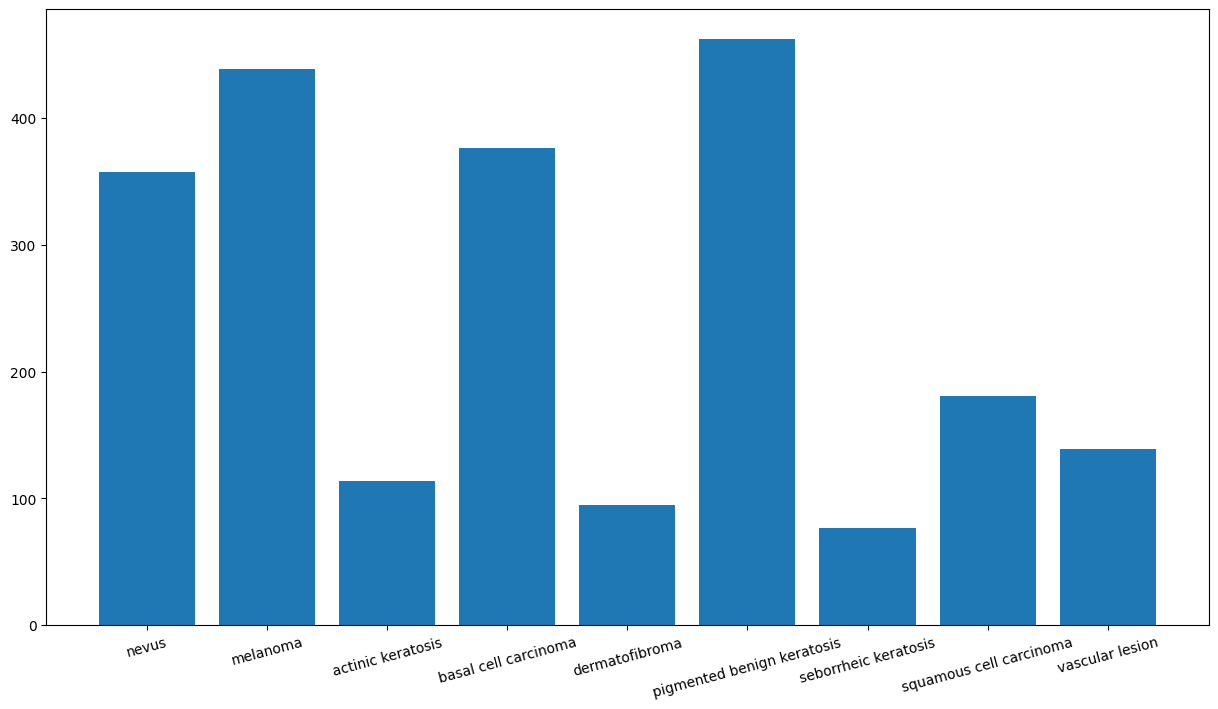

In [26]:
plt.figure(figsize=(15,8))
plt.bar(x=data_train['Folder'], height=data_train['Count'])

plt.xticks(rotation=15)
plt.show()

Classes are not distributed uniformly


1.   Seborrheic keraosis is least
2.   Pigmented benign keratosis is maximum

# Handling class imbalances

In [27]:
!pip install Augmentor

In [28]:
path_to_training_dataset='/content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E49BB907A30>: 100%|██████████| 500/500 [00:04<00:00, 111.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E49BB92E830>: 100%|██████████| 500/500 [00:04<00:00, 111.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E49BB95B850>: 100%|██████████| 500/500 [00:04<00:00, 109.57 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E4A4994FB80>: 100%|██████████| 500/500 [00:12<00:00, 39.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7E49BB92E320>: 100%|██████████| 500/500 [00:13<00:00, 38.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4A001A73A0>: 100%|██████████| 500/500 [00:05<00:00, 95.95 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E49BB958730>: 100%|██████████| 500/500 [00:06<00:00, 76.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E4A00535840>: 100%|██████████| 500/500 [00:04<00:00, 102.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4A4994FB80>: 100%|██████████| 500/500 [00:04<00:00, 114.46 Samples/s]


In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Adding new images to original images

In [30]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

Label
nevus                         500
melanoma                      500
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

The classes have uniform inage disribution

# Model Building & Training

Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [36]:
data_dir_train= '/content/gdrive/My Drive/Colab_Notebooks/CNN_assignment/modify1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
model = Sequential()

# Rescaling layer
model.add(normalize_layers)

# First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                        input_shape = (img_height, img_width, 32)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',
                        input_shape = (img_height, img_width, 32)))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Batch normalization
model.add(layers.BatchNormalization())
#Dropoutlayer
model.add(layers.Dropout(0.25))

#Second Convolution layer
model.add(layers.Conv2D(64, kernel_size=(5,5),activation='relu'))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Batch normalization
model.add(layers.BatchNormalization())
#Dropoutlayer
model.add(layers.Dropout(0.25))

#Third Convolution layer
model.add(layers.Conv2D(64, kernel_size=(5,5),activation='relu'))
# Maxpooling layer
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropoutlayer
model.add(layers.Dropout(0.5))

#Flatten layer
model.add(layers.Flatten())

#Dense layer
model.add(layers.Dense(len(class_names), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 88, 88, 32)        128       
 Normalization)                                                  
                                                                 
 dropout_4 (Dropout)         (None, 88, 88, 32)       

In [39]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [40]:
epochs =20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 47s 258ms/step - loss: 4.0021 - accuracy: 0.3292 - val_loss: 3.8392 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 16s 94ms/step - loss: 1.6951 - accuracy: 0.4557 - val_loss: 2.0449 - val_accuracy: 0.1663
Epoch 3/20
169/169 [==============================] - 16s 94ms/step - loss: 1.2531 - accuracy: 0.5599 - val_loss: 1.5735 - val_accuracy: 0.4373
Epoch 4/20
169/169 [==============================] - 17s 97ms/step - loss: 1.0779 - accuracy: 0.6211 - val_loss: 1.0851 - val_accuracy: 0.6310
Epoch 5/20
169/169 [==============================] - 17s 94ms/step - loss: 0.9192 - accuracy: 0.6741 - val_loss: 1.3668 - val_accuracy: 0.5316
Epoch 6/20
169/169 [==============================] - 16s 94ms/step - loss: 0.8640 - accuracy: 0.6983 - val_loss: 1.2732 - val_accuracy: 0.5375
Epoch 7/20
169/169 [==============================] - 17s 95ms/step - loss: 0.7606 - accuracy: 0.7385 - val_loss: 1.6179 - val_accuracy

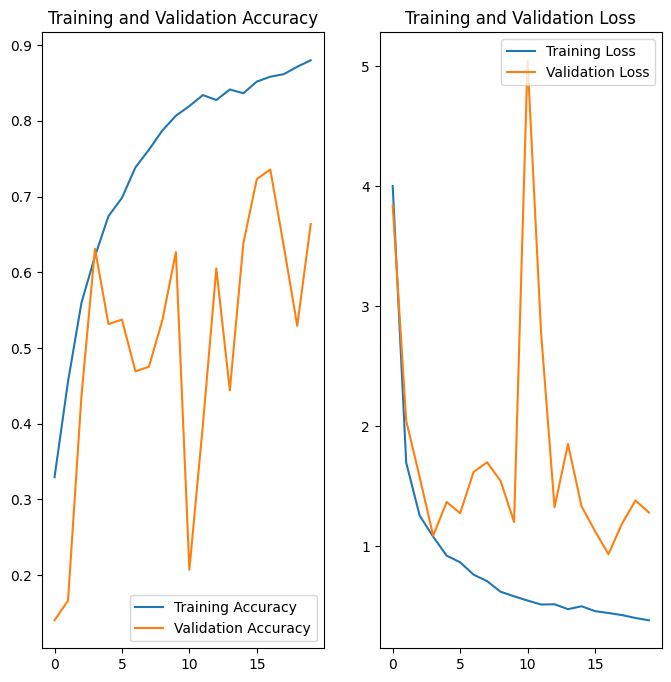

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 3s 61ms/step - loss: 1.2792 - accuracy: 0.6637
Accuracy:  0.7713279128074646
Validation Accuracy:  0.6636971235275269
Loss:  0.7160059809684753
Validation Loss 1.27922523021698


We could see
We could see
*   Model is overfit
*   The difference is reduced
*   Accuracy of validation set has increased

The class rebalance  with extra layer of Batchnormalization in model architecture structure have helped to reduce overfitting but cannot completely removed it

Adding more images to class rebalance may improve training process and reduce overfiiting




